In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [12]:
import glob
import tqdm.auto as tqdm
import numpy as np
import PIL.Image
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colorbar import Colorbar
import seaborn

from cv2 import resize

In [13]:
folders = glob.glob("D:\\MediSAR/KAGGLE-*/*/*")
folders = [folder for folder in folders if 'owi_wind_speed_256.png' in os.listdir(folder)]
print(f'{len(folders)} folders with wind data')

72787 folders with wind data


In [14]:
discrepancies = []

wind_array = np.zeros((256, 256), int)
for folder in tqdm.tqdm(folders, smoothing=0.001):
    owi_wind_speed = np.array(PIL.Image.open(folder + '/owi_wind_speed_256.png'))
    dl_wind_speed = np.array(PIL.Image.open(folder + '/unet_wind_speed_256.png'))
    
    owi_wind_speed = owi_wind_speed[dl_wind_speed != 0]
    dl_wind_speed = dl_wind_speed[dl_wind_speed != 0]
    
    validity = np.logical_and(
        owi_wind_speed < 256,
        dl_wind_speed < 256
    )
    owi_wind_speed = owi_wind_speed[validity]
    dl_wind_speed = dl_wind_speed[validity]
    
    np.add.at(wind_array, (owi_wind_speed, dl_wind_speed), np.ones(owi_wind_speed.shape))
    discrepancies.append((abs(owi_wind_speed/10-dl_wind_speed/10).mean(), folder, owi_wind_speed.shape[0]))

  0%|          | 0/72787 [00:00<?, ?it/s]

C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


C:\Users\Rignak\AppData\Local\Programs\Python\Python37\Lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


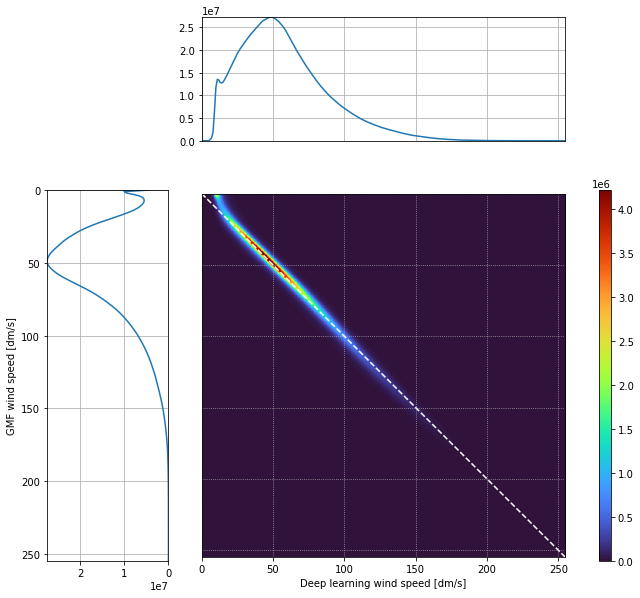

In [15]:
plt.figure(figsize=(10.1,10), layout="constrained")
gs = gridspec.GridSpec(2, 3, width_ratios=[1,3,0.1], height_ratios=[1,3])

ax = plt.subplot(gs[1,1])

vmax = (wind_array * (1-np.eye(256))).max()
m = ax.imshow(wind_array, vmin=0, vmax=vmax, cmap='turbo')
ax.plot((0, 256), (0,256), c='white', linestyle='--')
ax.set_ylim(0,255)
ax.set_xlim(0,255)
ax.grid(linestyle='dotted')

ax1 = plt.subplot(gs[1,0], sharey=ax)
sumed = np.sum(wind_array, axis=1)
ax1.plot(sumed, range(256))
ax1.set_ylim(255,0)
ax1.set_xlim(np.nanpercentile(sumed, 100), 0)
ax1.grid()

ax2 = plt.subplot(gs[0,1], sharex=ax)
sumed = np.sum(wind_array, axis=0)
ax2.plot(range(256), sumed)
ax2.set_xlim(0,255)
ax2.set_ylim(0, np.percentile(sumed, 100))
ax2.grid()


cb = Colorbar(ax = plt.subplot(gs[1,2]), mappable = m)

ax1.set_ylabel("GMF wind speed [dm/s]")
ax.set_xlabel("Deep learning wind speed [dm/s]")
ax2.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

plt.show()
plt.close()

In [16]:
seasons = {
    f'{year}-{season}': [[], 0, 0] 
    for year in range(2014, 2023) for season in ('DJF', 'MAM', 'JJA', 'SON')
}

for mae, folder, surface in discrepancies:
    folder = os.path.split(folder)[1]
    season = ('DJF', 'DJF', 'MAM', 'MAM', 'MAM', 'JJA', 'JJA', 'JJA', 'SON', 'SON', 'SON', 'DJF')[int(folder[4:6])-1]
    year = int(folder[:4])
    if folder[4:6] == '12': year += 1
    season = f'{year}-{season}'
    if season == "2023-DJF": continue
    
    seasons[season][0].append(mae)
    seasons[season][1] += mae*surface
    seasons[season][2] += surface

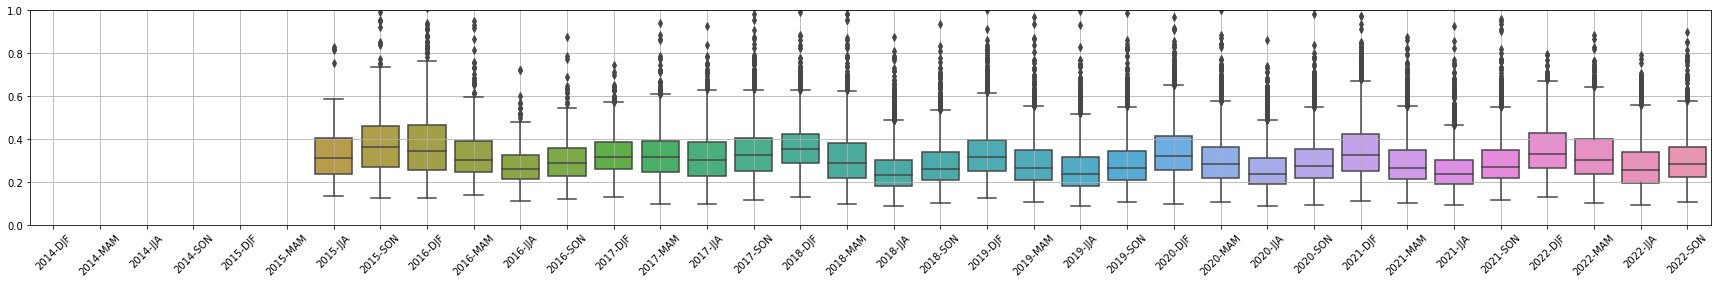

In [17]:
plt.figure(figsize=(24,4))

xs = range(len(seasons))
seaborn.boxplot(data=[e[0] for e in seasons.values()])
plt.xticks(xs, list(seasons.keys()), rotation=45)
plt.grid()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()
plt.close()

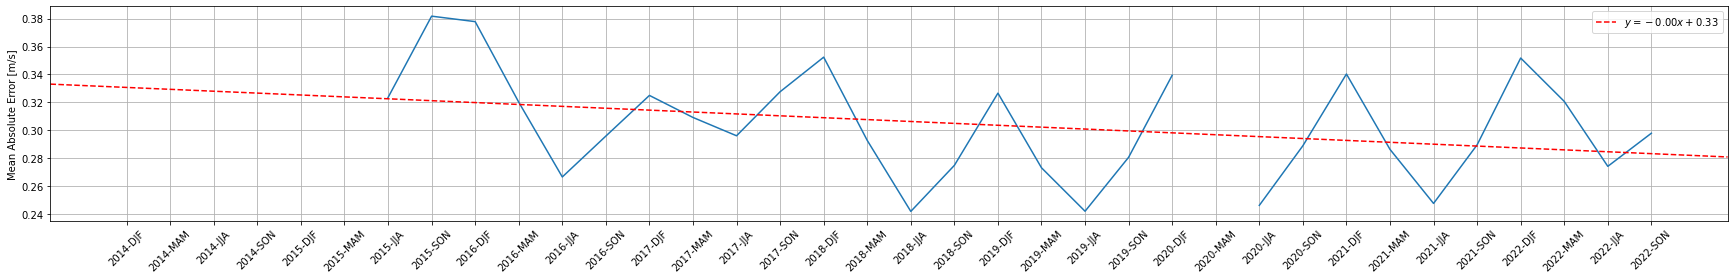

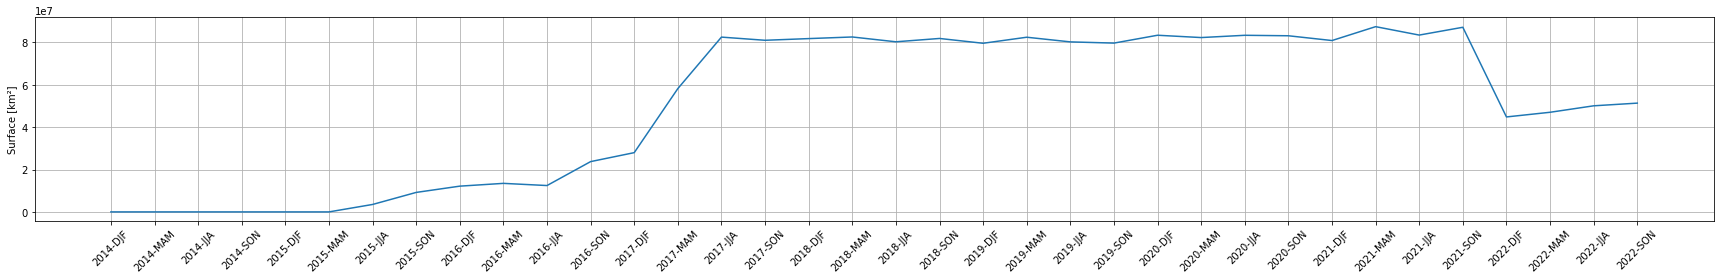

In [18]:

def safe_division(a, b):
    return a/b if b else np.nan

ys = [safe_division(e[1], e[2]) for e in seasons.values()]

m, b = np.polyfit(
    [x for (x, y) in zip(xs, ys) if not np.isnan(y)], 
    [y for (x, y) in zip(xs, ys) if not np.isnan(y)], deg=1
)

plt.figure(figsize=(24,4))
plt.plot(xs, ys)
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.2f}x {b:+.2f}$', linestyle='dashed', color='red')
plt.legend()

plt.xticks(xs, list(seasons.keys()), rotation=45)
plt.grid()
plt.tight_layout()
plt.ylabel('Mean Absolute Error [m/s]')
plt.show()
plt.close()

ys = [e[2] for e in seasons.values()]

plt.figure(figsize=(24,4))
plt.plot(xs, ys)
plt.ylabel('Surface [km²]')
plt.xticks(xs, list(seasons.keys()), rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
plt.close()

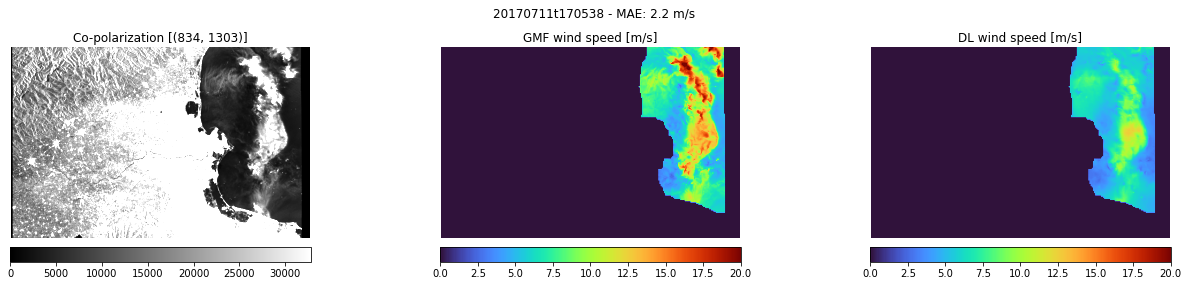

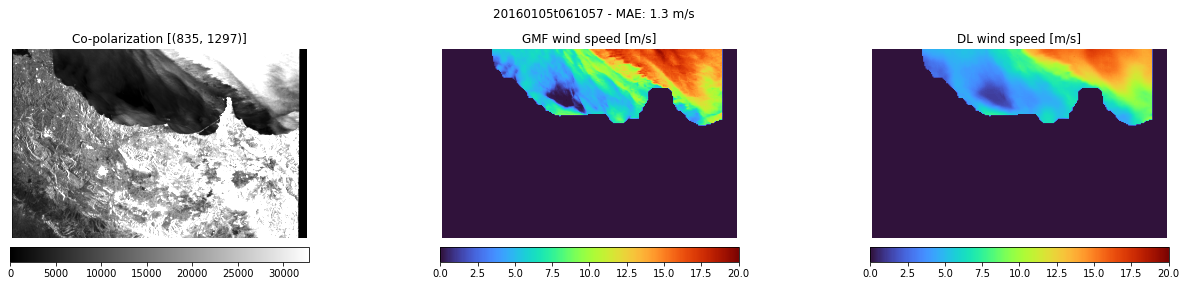

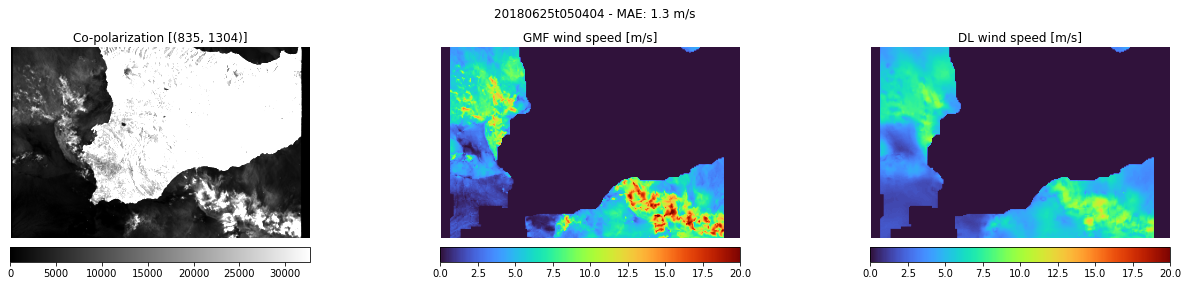

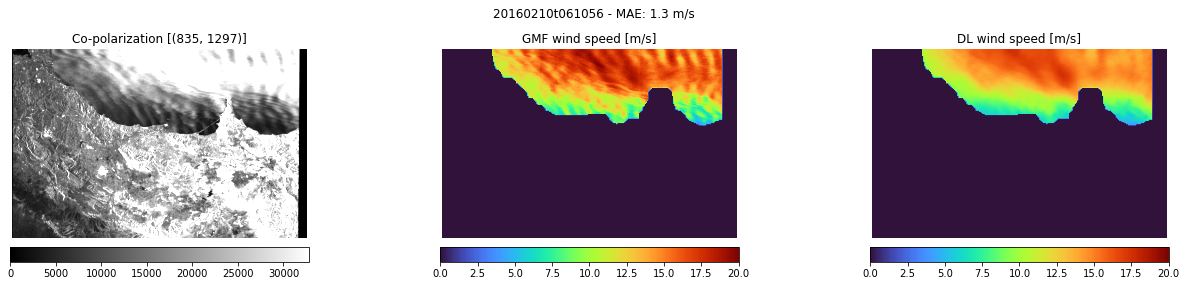

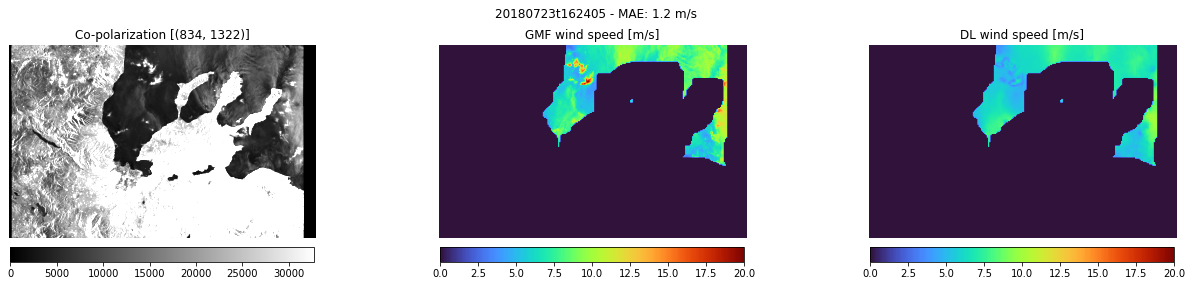

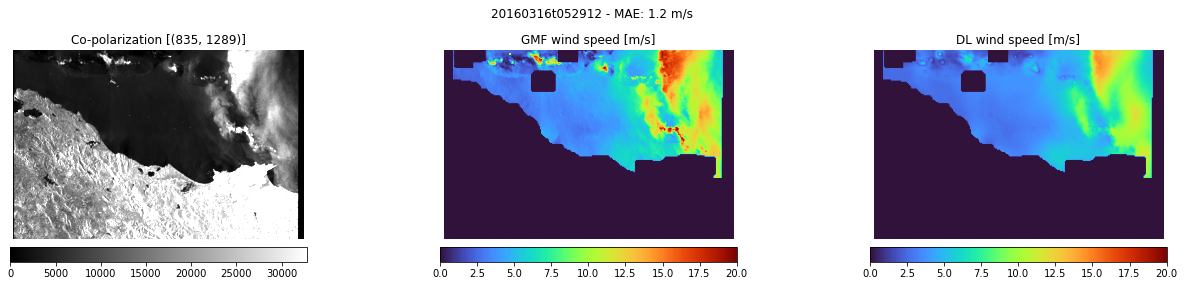

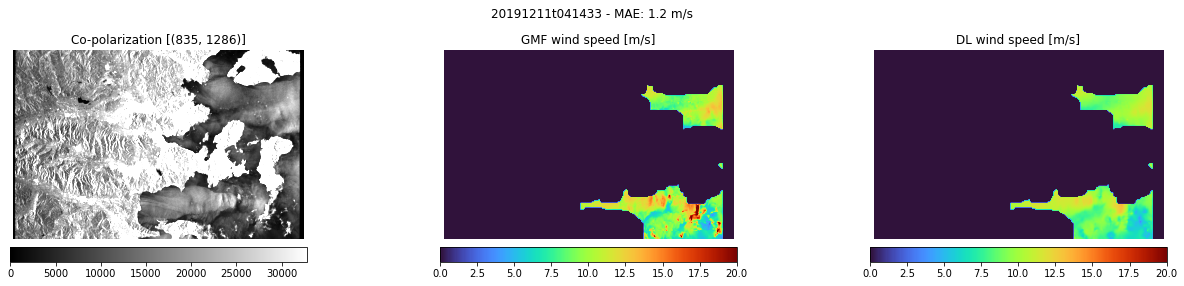

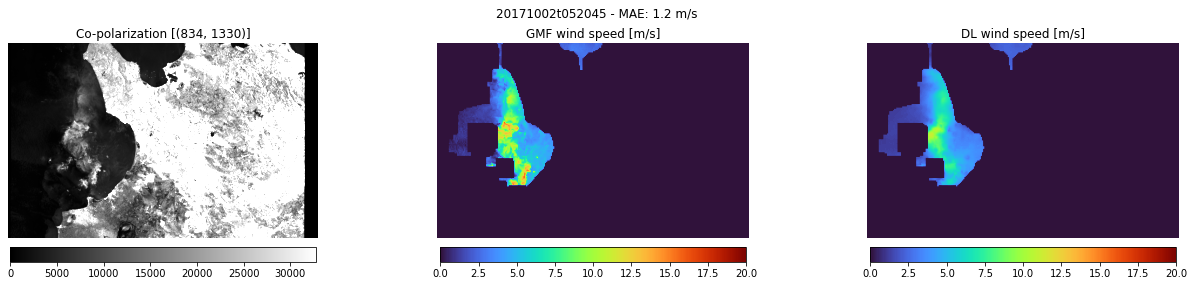

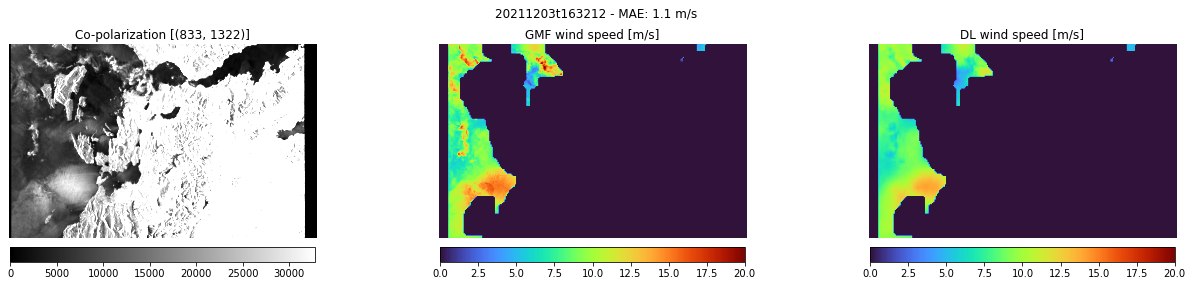

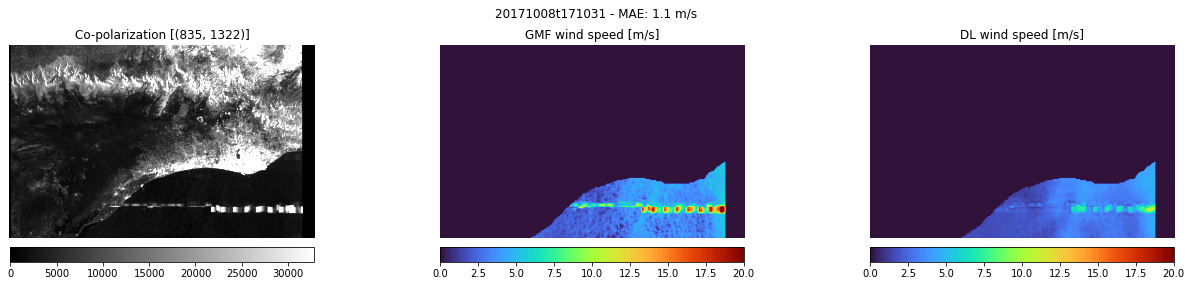

In [19]:
discrepancies = sorted(discrepancies, reverse=True)

redo = []
for i, (mae, folder, surface) in enumerate(discrepancies):
    if i < 10:
        iw = np.array(PIL.Image.open(glob.glob(folder + '/*-vv-*')[0]))
        owi_wind_speed = np.array(PIL.Image.open(folder + '/owi_wind_speed_256.png'))/10
        dl_wind_speed = np.array(PIL.Image.open(folder + '/unet_wind_speed_256.png'))/10

        plt.figure(figsize=(18,4))
        plt.suptitle(f"{os.path.split(folder)[1]} - MAE: {mae:.1f} m/s")

        plt.subplot(131)
        plt.title(f'Co-polarization [{iw.shape}]')
        plt.imshow(iw, cmap='gray', vmin=0, vmax=2**15)
        plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
        plt.axis('off')

        plt.subplot(132)
        plt.title(f'GMF wind speed [m/s]')
        plt.imshow(owi_wind_speed, cmap='turbo', vmin=0, vmax=20)
        plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
        plt.axis('off')

        plt.subplot(133)
        plt.title(f'DL wind speed [m/s]')
        plt.imshow(dl_wind_speed, cmap='turbo', vmin=0, vmax=20)
        plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.04)
        plt.axis('off')

        plt.tight_layout()

    if mae > 10:
        redo.append((folder, mae))
        for filename in ('/owi_wind_speed_256.png', '/unet_wind_speed_256.png', '/owi_wind_speed_512.png', '/unet_wind_speed_512.png'):
            os.remove(folder + filename)